In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [3]:
txt_size = 500
epochs = 3
mini_batch = 30

In [4]:
## 트레이닝 데이터셋이 저장된 파일을 읽고,
## csv 파일의 첫째항부터 열이름 없이 데이터가 저장되어 있어서
## 첫번째 데이터가 자꾸 column명으로 입력되길래 당황했다.
## 새로운 행을 추가하는 방법도 생각해 봤는데 어려웠고...
## 그래서 그냥 새로 만든 데이터프레임에 columns 명을 프로그램 안에서 지정해 주기로 했다.

df_train = pd.read_csv("MBTI_train.csv", names=["MBTI", "words"])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74357 entries, 0 to 74356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MBTI    74357 non-null  object
 1   words   74357 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
df_train.head(5)

,MBTI,words
0,INTP,say process model list like subscriber channel...
1,INFJ,upon much manipulate retail finish like sacrif...
2,INFJ,fit yes certain bff social feel goal go know n...
3,INTJ,complete love within someone ideal joke solvea...
4,ENTJ,public strictly thing person x question person...


In [6]:
df_val_test = df_train.drop(df_train.index).copy()
df_val = df_val_test.sample(frac=0.5, random_state=5).copy()

In [7]:
## words를 학습데이터로 삼으면서
## 각각의 words에 해당 MBTI 라벨을 붙였다.
## 트레이닝용, 검증용 따로 정의함.

labels_train = df_train['MBTI'].values
data_train = df_train['words'].values

labels_val = df_val['MBTI'].values
data_val = df_val['words'].values

le = LabelEncoder()
en_labels_train = le.fit_transform(labels_train)
en_labels_val = le.transform(labels_val)

Text(0.5, 1.0, 'MBTI COUNT')

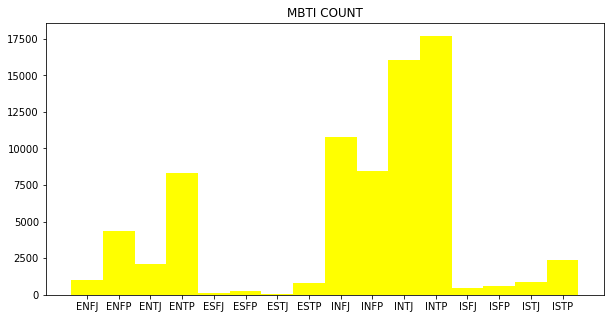

In [18]:
## 트레이닝 데이터셋 파일에 있던
## 각각의 MBTI 종류별로 존재하는 데이터량을
## 그래프로 시각화함
## 나중에 보니까 진짜 INTP INTJ가 대부분이더라...

unique_labels, count = np.unique(df_train['MBTI'], return_counts=True)
fig = plt.figure(figsize=(10,5))
plt.bar(unique_labels, count, color="YELLOW", width=1)
plt.title("MBTI COUNT")

In [9]:
## 단어들 토큰화 진행

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(data_train)

In [10]:
## 데이터 패딩하는 함수 정의

def pad_data(tokenizer, data2pad, maxlen):
    sequence = tokenizer.texts_to_sequences(data2pad)
    paded = pad_sequences(sequence, truncating='post', padding='post', maxlen=maxlen)
    return paded

In [11]:
## 훈련 데이터, 검증 데이터 각각 패딩

paded_data_train = pad_data(tokenizer, data_train, txt_size)
paded_data_val = pad_data(tokenizer, data_val, txt_size)

KeyboardInterrupt: 

In [ ]:
paded_data_train.shape

(74357, 500)

In [ ]:
# 데이터 vectorize

def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1) 
    return vectorize_layer(text), label 

max_features = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(data_train)
vect_train = vectorize_layer(data_train)
vect_val = vectorize_layer(data_val)

In [ ]:
## 모델 생성하는 함수 정의

def create_model(post_size, num_labels):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    
    x = layers.Embedding(10000, 128)(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_labels, activation="sigmoid", name="predictions")(x)
    model = tf.keras.Model(inputs, predictions)
    return model

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
model_token = create_model(txt_size, len(unique_labels))
model_token.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_token.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [ ]:
## 모델 훈련시키기

history_token = model_token.fit(
    paded_data_train, en_labels_train,
    validation_data = (paded_data_val, en_labels_val),
    epochs = epochs,
    batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/2
2324/2324 [==============================] - 440s 188ms/step - loss: 1.6179 - accuracy: 0.4867
Epoch 2/2
2324/2324 [==============================] - 368s 158ms/step - loss: 1.1303 - accuracy: 0.6628


In [ ]:
## 이제 테스트할 차례
## 테스트 데이터셋 저장된 파일 불러오기

text_batch = data_val
label_batch = data_val

df_test = pd.read_csv("MBTI_test.csv", names=["words"])
df_test['MBTI'] = np.nan
df_test = df_test[['MBTI', 'words']]
df_test = df_test.astype({'MBTI':'object'})
df_test.info()

labels_test = df_test['MBTI'].values
data_test = df_test['words'].values
paded_data_test = pad_data(tokenizer, data_test, txt_size)
vect_test = vectorize_layer(data_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9337 entries, 0 to 9336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MBTI    0 non-null      object
 1   words   9337 non-null   object
dtypes: object(2)
memory usage: 146.0+ KB


In [ ]:
## 예측 모델 생성

inference = model_token.predict_on_batch(vect_test)

In [ ]:
## 예측한 값을 새로운 데이터프레임에 넣어주고
## columns명을 각 MBTI로 설정

resultDF = pd.DataFrame(inference)
resultDF.columns = unique_labels
resultDF.head()


,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,0.518537,0.989429,0.072004,0.066087,0.006665,0.025757,1.952052e-04,0.000047,0.697332,0.780481,0.119343,0.013228,0.058952,0.150026,0.098208,0.005113
1,0.153921,0.094294,0.287124,0.995333,0.000529,0.004937,1.101356e-04,0.029807,0.781314,0.278508,0.384041,0.600946,0.030973,0.026916,0.035131,0.070328
2,0.028955,0.952374,0.745793,0.395842,0.000196,0.001102,5.260671e-07,0.000202,0.315601,0.233377,0.997885,0.508927,0.000259,0.001736,0.152442,0.027656
3,0.007937,0.543518,0.875947,0.658192,0.000013,0.000069,1.299200e-08,0.000313,0.363087,0.161309,0.999893,0.970863,0.000051,0.000093,0.262920,0.078813
4,0.090935,0.058578,0.739373,0.600214,0.001548,0.000593,4.480776e-05,0.009818,0.129361,0.391241,0.996780,0.999143,0.000492,0.004174,0.163630,0.702166


In [ ]:
result = resultDF.max(axis=1)

result.head()

0    0.989429
1    0.995333
2    0.997885
3    0.999893
4    0.999143
dtype: float32

In [ ]:
result = resultDF.idxmax(axis=1)
result.head()

0    ENFP
1    ENTP
2    INTJ
3    INTJ
4    INTP
dtype: object

In [ ]:
result = pd.DataFrame(result, columns=['MBTI'])
result.to_csv("Final_result_team14.csv", index=False, header=False)